In [11]:
import os
import splitfolders 

In [12]:
pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
input_dir = os.path.join('/content/drive/MyDrive/flowers')
output_dir = os.path.join('/content/drive/MyDrive/flowers_splitted')
splitfolders.ratio(input_dir, output=output_dir, seed=1337, ratio=(.8, .2), group_prefix=None) 


Copying files: 4317 files [43:43,  1.65 files/s]


In [5]:
train_dir = os.path.join('/content/drive/MyDrive/flowers_splitted/train/')
test_dir = os.path.join('/content/drive/MyDrive/flowers_splitted/val/')

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def image_generator(train_parent_directory, test_parent_directory):
    
    train_datagen = ImageDataGenerator(rescale=1/255)
    test_datagen = ImageDataGenerator(rescale=1/255)
    
    train_generator = train_datagen.flow_from_directory(train_parent_directory,
                                  target_size = (75,75),
                                  batch_size = 214,
                                  class_mode = 'categorical',
                                  subset='training')
 
    
    test_generator = test_datagen.flow_from_directory(test_parent_directory,
                                 target_size=(75,75),
                                 batch_size = 37,
                                 class_mode = 'categorical')    
    
    return train_generator, test_generator

In [7]:
train_generator, test_generator = image_generator(train_dir, test_dir)

Found 3452 images belonging to 5 classes.
Found 865 images belonging to 5 classes.


Standard CNN Model

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout

model = Sequential([
    Conv2D(input_shape=(75,75,3), filters=8, kernel_size=16, activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(units=5, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 60, 60, 8)         6152      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        2336      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 64)         0

In [9]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
history = model.fit(
      train_generator,
      steps_per_epoch=10,  
      epochs=50,
      verbose=1)

Epoch 1/50
10/10 [==============================] - 18s 555ms/step - loss: 1.5924 - accuracy: 0.2426
Epoch 2/50
10/10 [==============================] - 6s 593ms/step - loss: 1.4384 - accuracy: 0.3454
Epoch 3/50
10/10 [==============================] - 7s 647ms/step - loss: 1.3030 - accuracy: 0.4196
Epoch 4/50
10/10 [==============================] - 6s 589ms/step - loss: 1.2712 - accuracy: 0.4463
Epoch 5/50
10/10 [==============================] - 6s 587ms/step - loss: 1.2440 - accuracy: 0.4729
Epoch 6/50
10/10 [==============================] - 6s 592ms/step - loss: 1.2082 - accuracy: 0.4918
Epoch 7/50
10/10 [==============================] - 6s 584ms/step - loss: 1.1876 - accuracy: 0.5046
Epoch 8/50
10/10 [==============================] - 6s 589ms/step - loss: 1.1903 - accuracy: 0.4974
Epoch 9/50
10/10 [==============================] - 6s 597ms/step - loss: 1.1703 - accuracy: 0.5092
Epoch 10/50
10/10 [==============================] - 6s 596ms/step - loss: 1.1056 - accuracy: 0.549

In [13]:
import matplotlib.pyplot as plt
import numpy as np

[[1.4438989e-02 9.2982763e-01 5.0865680e-02 4.8731186e-04 4.3804687e-03]]


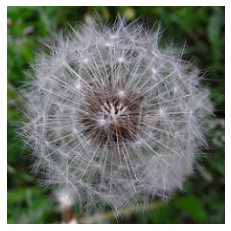

In [14]:
import cv2

def import_and_predict(image_data, label):
    
    #read image
    img = cv2.imread(image_data)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    
    #show the image
    plt.imshow(img)
    plt.axis('off')
    
    # resize and reshape the image
    img_resize = (cv2.resize(img, dsize=(75, 75), interpolation=cv2.INTER_CUBIC))/255.
    
    img_reshape = img_resize[np.newaxis,...]
    
    #predict the image
    prediction = model.predict(img_reshape)
    print(prediction)
    
    label_prediction = label[np.argmax(prediction)]
    
    return label_prediction
 
label = os.listdir(test_dir)
image1_dir = os.path.join(test_dir+'dandelion/3696596109_4c4419128a_m.jpg')

prediction = import_and_predict(image1_dir, label)

Building Bayesian Neural network.

In [15]:
pip install tensorflow-probability 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [16]:
import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions
tfpl = tfp.layers

The differences between CNN and bayesian CNN is the first convolutional layer and the last dense layer of the model

Instead of using a normal CNN Conv2D layer, we are going to use Convolutional2DReparameterization layer. The point of this layer is to take aleatoric uncertainty into account, which is the uncertainty that arises from the quality of the data

 This layer creates an output from a distribution

Prior for kernel and bias parameters: this is the prior belief on how the distribution looks like before the data is taken into account

In [17]:
kernel_prior_fn = tfpl.default_multivariate_normal_fn
bias_prior_fn = tfpl.default_multivariate_normal_fn,

Posterior for kernel and bias parameters — this is the posterior belief on how the distribution looks like after seeing the evidence from data. As this is a belief after seeing the data, then we need to define the posterior with trainable parameters

In [18]:
kernel_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular=False)
bias_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular=False)

Kullback-Leibler divergence — this is the method to measure how one distribution is different from the reference distribution. For our case, this method is used to measure the divergence of our prior and posterior. The lower the value, or when its value is 0, it means that two distributions are coming from the same distribution

In [19]:
divergence_fn = lambda q,p,_:tfd.kl_divergence(q,p)/3457
kernel_divergence_fn = divergence_fn
bias_divergence_fn = divergence_fn

In [32]:
divergence_fn = lambda q,p,_:tfd.kl_divergence(q,p)/3457

model_bayes = Sequential([
    
    tfpl.Convolution2DReparameterization(input_shape=(75,75,3), filters=8, kernel_size=16, activation='relu',
                                           kernel_prior_fn = tfpl.default_multivariate_normal_fn,
                                           kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                           kernel_divergence_fn = divergence_fn,
                                           bias_prior_fn = tfpl.default_multivariate_normal_fn,
                                           bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                           bias_divergence_fn = divergence_fn),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.2),
    tfpl.DenseReparameterization(units=tfpl.OneHotCategorical.params_size(5), activation=None,
                                    kernel_prior_fn = tfpl.default_multivariate_normal_fn,
                                    kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                    kernel_divergence_fn = divergence_fn,
                                    bias_prior_fn = tfpl.default_multivariate_normal_fn,
                                    bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                    bias_divergence_fn = divergence_fn
                                ),
    tfpl.OneHotCategorical(5)
    
])
model_bayes.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_reparameterization_1  (None, 60, 60, 8)        12304     
  (Conv2DReparameterization)                                     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 30, 30, 8)        0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 32)        2336      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 12, 12, 64)        18496     
                                                      

In [33]:
from tensorflow.keras.optimizers import Adam

def negative_log_likelihood(y_true, y_pred):
    return -y_pred.log_prob(y_true)

model_bayes.compile(loss = negative_log_likelihood,
              optimizer = Adam(learning_rate=0.005),
              metrics = ['accuracy'],
              experimental_run_tf_function = False)

In [34]:

history_bayes = model_bayes.fit(
      train_generator,
      epochs=300,
      verbose=1)

Epoch 1/300
17/17 [==============================] - 13s 614ms/step - loss: 7.9852 - accuracy: 0.2123
Epoch 2/300
17/17 [==============================] - 11s 635ms/step - loss: 7.7719 - accuracy: 0.2063
Epoch 3/300
17/17 [==============================] - 11s 619ms/step - loss: 7.6136 - accuracy: 0.2022
Epoch 4/300
17/17 [==============================] - 10s 613ms/step - loss: 7.4330 - accuracy: 0.2042
Epoch 5/300
17/17 [==============================] - 11s 617ms/step - loss: 7.2592 - accuracy: 0.2083
Epoch 6/300
17/17 [==============================] - 11s 615ms/step - loss: 7.0834 - accuracy: 0.2057
Epoch 7/300
17/17 [==============================] - 11s 620ms/step - loss: 6.9071 - accuracy: 0.2092
Epoch 8/300
17/17 [==============================] - 11s 621ms/step - loss: 6.7256 - accuracy: 0.2106
Epoch 9/300
17/17 [==============================] - 11s 615ms/step - loss: 6.5504 - accuracy: 0.2034
Epoch 10/300
17/17 [==============================] - 11s 615ms/step - loss: 6.366

In [36]:
def import_and_predict_bayes(image, true_label):

    #read image
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    
    #show the image
    plt.imshow(img)
    plt.axis('off')
    
    img_resize = (cv2.resize(img, dsize=(75, 75), interpolation=cv2.INTER_CUBIC))/255.
    
    predicted_probabilities = np.empty(shape=(300, 5))
    
    for i in range(300):
        
        predicted_probabilities[i] = model_bayes(img_resize[np.newaxis,...]).mean().numpy()[0]
        
    pct_2p5 = np.array([np.percentile(predicted_probabilities[:, i], 2.5) for i in range(5)])
    pct_97p5 = np.array([np.percentile(predicted_probabilities[:, i], 97.5) for i in range(5)])
    
    fig, ax = plt.subplots(figsize=(12, 6))
    bar = ax.bar(np.arange(5), pct_97p5, color='red')
    bar[true_label].set_color('green')
    bar = ax.bar(np.arange(5), pct_2p5-0.02, color='white')
    ax.set_xticklabels([''] + [x for x in label])
    ax.set_ylim([0, 1])
    ax.set_ylabel('Probability')
    plt.show()